In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Anomaly Detection Implemented on HAM10000

In [ ]:
# @title Project done by: Sofia Guerrero and Nayara Vasques

In [ ]:
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hmnist_28_28_RGB.csv')
df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


In [ ]:
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming your dataset is named 'data'
# Splitting into train and test sets (80% train, 20% test)
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Verify the shapes of the train and test sets
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (8012, 2353)
Test shape: (2003, 2353)


In [ ]:
label_counts = df['label'].value_counts()
print(label_counts)

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64


In [ ]:
#@title Classes



0: 'nv' - Melanocytic nevus
1: 'mel' - Melanoma
2: 'bkl' - Benign keratosis
3: 'bcc' - Basal cell carcinoma
4: 'akiec' - Actinic keratosis
5: 'vasc' - Vascular lesion
6: 'df' - Dermatofibroma

In [ ]:
# Define anom and clean labels
anom_labels = [1, 3, 4]
clean_labels = [0, 2, 5, 6]

# Filter label_counts dictionary to separate anomaly and normal classes
anom_counts = label_counts[label_counts.index.isin(anom_labels)]
clean_counts = label_counts[label_counts.index.isin(clean_labels)]

# Print the counts for anomaly and normal classes
print("Anomaly Class Counts:")
print(anom_counts)
print("\nNormal Class Counts:")
print(clean_counts)


Anomaly Class Counts:
label
4    6705
1     514
3     115
Name: count, dtype: int64

Normal Class Counts:
label
6    1113
2    1099
0     327
5     142
Name: count, dtype: int64


In [ ]:
# Filter anomalies (classes 1, 3, and 4)
anom = df[df['label'].isin([1, 3, 4])]

# Filter clean (classes 0, 2, 5, and 6)
clean = df[df['label'].isin([0, 2, 5, 6])]


In [ ]:
anom['label'] = 1
clean['label'] = 0

<ipython-input-16-7803411b1b46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anom['label'] = 1
<ipython-input-16-7803411b1b46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['label'] = 0


In [ ]:
#Saving new test data

In [ ]:
anom.shape

(7334, 2353)

In [ ]:
clean.shape

(2681, 2353)

In [ ]:
train.shape

(8012, 2353)

In [ ]:
train.head(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
6582,229,148,167,231,147,168,231,146,170,231,...,218,146,152,217,148,152,215,147,153,4
7194,159,105,143,159,100,137,158,97,131,161,...,182,146,179,179,134,170,172,118,153,4
9446,10,5,8,56,35,45,106,74,90,132,...,133,104,123,111,83,101,73,49,64,4
533,150,137,132,158,149,153,165,156,163,167,...,137,123,128,126,110,107,120,105,98,2
132,131,119,140,136,124,140,140,128,146,144,...,152,143,156,147,136,147,143,131,142,2
4883,226,152,174,228,154,175,229,159,178,229,...,223,164,172,221,162,170,219,160,167,4
8471,175,135,133,179,140,137,189,154,149,190,...,197,160,161,188,146,149,176,127,133,4
964,145,109,115,164,127,131,169,132,133,175,...,174,142,150,165,125,132,152,113,111,2
9704,202,152,160,203,157,166,204,149,154,206,...,210,155,148,210,162,166,210,169,182,0
9354,180,155,192,181,157,195,180,156,196,180,...,170,128,169,168,128,170,167,127,170,4


In [ ]:
anom.head(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
64,163,135,159,167,140,166,170,144,169,170,...,167,144,167,165,141,164,160,136,155,1
1095,172,132,123,196,152,144,204,162,158,205,...,156,117,103,108,74,69,46,25,27,1
1096,220,172,181,229,180,179,240,193,197,242,...,243,195,193,243,199,204,239,195,196,1
1097,222,192,220,226,196,228,220,191,223,220,...,226,199,233,226,198,230,218,190,222,1
1098,61,43,53,134,109,120,180,157,166,192,...,140,120,132,62,47,58,13,8,18,1
1099,197,156,162,201,157,164,201,154,161,201,...,205,162,173,203,158,164,204,162,168,1
1100,21,10,11,72,45,40,126,92,83,151,...,28,14,14,13,4,2,16,5,3,1
1101,74,56,64,136,113,123,162,130,140,165,...,154,127,144,75,57,69,16,4,11,1
1102,221,170,168,227,178,186,232,184,201,231,...,234,180,187,232,181,187,226,172,185,1
1103,32,13,26,24,9,21,78,61,79,151,...,31,13,27,24,10,20,14,4,10,1


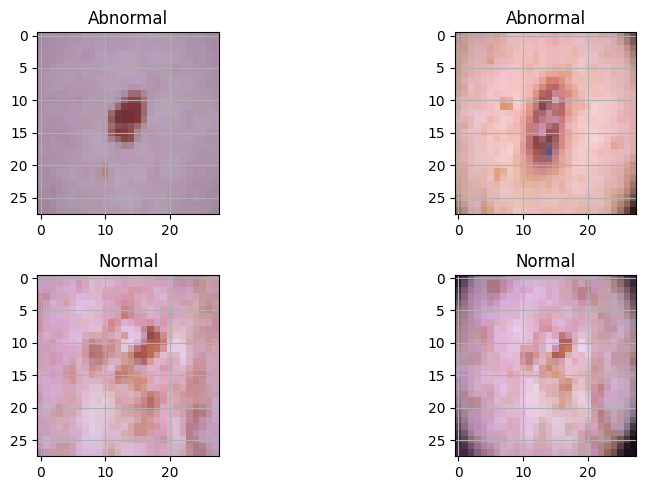

In [ ]:
import matplotlib.pyplot as plt

# Plot abnormal images
plt.figure(figsize=(10, 5))
for i in range(2):  # Plot two abnormal images
    img = anom.iloc[i, :-1]
    img = img.values.reshape(28, 28, 3)  # Reshape to a 28x28x3 image
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.imshow(img)
    plt.title('Abnormal')
    plt.grid()

# Plot normal images
for i in range(2):  # Plot two normal images
    img = clean.iloc[i, :-1]  # Assuming pixel values are from the first to the second-to-last column
    img = img.values.reshape(28, 28, 3)  # Reshape to a 28x28x3 image
    plt.subplot(2, 2, i + 3)  # Start from the third subplot
    plt.imshow(img)
    plt.imshow(img)
    plt.title('Normal')
    plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# @title AUTO ENCODER:



In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(2352, 512),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )


        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 2352),  # Adjusted output size to match the bottleneck size
            nn.ReLU()
        )




    def forward(self, x):
      encode = self.enc(x)
      #print("Encoded shape:", encode.shape)  # Print shape of encoded tensor
      decode = self.dec(encode)
      #print("Decoded shape:", decode.shape)  # Print shape of decoded tensor
      return decode




In [ ]:
batch_size = 64
lr = 1e-3         # learning rate
epochs = 150

In [ ]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        label = row['label']
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)/255).float()
        data = data.view(-1)
        return data, label

class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__()
        self.dataset = train

In [ ]:
train_set = Train_Loader()
train_loader = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=20,
            pin_memory=True,
            drop_last=True
        )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data, _) in enumerate(train_loader):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('Epoch {}/{}\n Loss {}'.format(epoch+1,epochs,epoch_loss))
   # print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


-----------------------------------------------
Epoch 1/150
 Loss 0.002752974973475403
-----------------------------------------------
Epoch 2/150
 Loss 0.0024313421634454104
-----------------------------------------------
Epoch 3/150
 Loss 0.0024159117934261032
-----------------------------------------------
Epoch 4/150
 Loss 0.0024032733118123433
-----------------------------------------------
Epoch 5/150
 Loss 0.0023728009523508614
-----------------------------------------------
Epoch 6/150
 Loss 0.0023349615700144918
-----------------------------------------------
Epoch 7/150
 Loss 0.0023136674145192906
-----------------------------------------------
Epoch 8/150
 Loss 0.002302658523298536
-----------------------------------------------
Epoch 9/150
 Loss 0.0022994168195734008
-----------------------------------------------
Epoch 10/150
 Loss 0.0022870886399486453
-----------------------------------------------
Epoch 11/150
 Loss 0.002256252740138302
---------------------------------

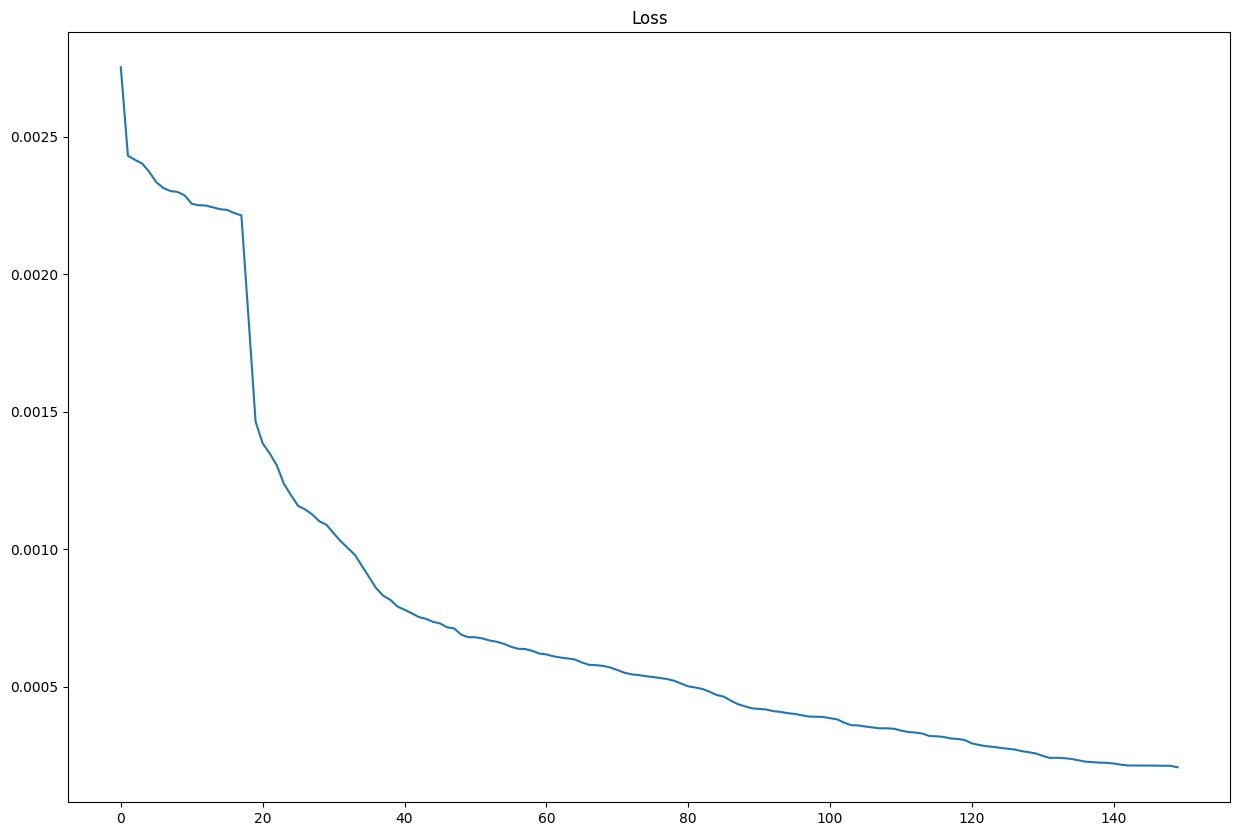

In [ ]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss']);

In [ ]:
# @title Evaluation:

In [ ]:
class Test_Loader(Loader):
    def __init__(self):
        super(Test_Loader, self).__init__()
        self.dataset = test

In [ ]:
test_set = Test_Loader()
test_loader = torch.utils.data.DataLoader(
            test_set,
            batch_size=batch_size,
            shuffle=False,
            num_workers=20,
            pin_memory=True,
            drop_last=False
        )

In [ ]:
model.eval()
loss_dist = []
labels = []
with torch.no_grad():
  for bx, (data, lbl) in enumerate(test_loader):
    sample = model(data.to(device))
    loss = F.mse_loss(data.to(device), sample, reduction='none').mean(1).flatten().cpu().numpy()
    loss_dist.extend(loss.tolist())
    labels.extend(lbl.tolist())

loss_dist = np.array(loss_dist)
labels = np.array(labels)

In [ ]:
model.eval()
loss_dist = []
labels = []
anom = df[df['label'].isin([1, 3, 4])]  # Filter anomalies (classes 1, 3, and 4)
clean = df[df['label'].isin([0, 2, 5, 6])]  # Filter clean (classes 0, 2, 5, and 6)

with torch.no_grad():
    for bx, (data, lbl) in enumerate(test_loader):
        sample = model(data.to(device))
        loss = F.mse_loss(data.to(device), sample, reduction='none').mean(1).flatten().cpu().numpy()
        loss_dist.extend(loss.tolist())
        labels.extend(lbl.tolist())

loss_dist = np.array(loss_dist)
labels = np.array(labels)



In [ ]:
# @title Plotting Distributions:

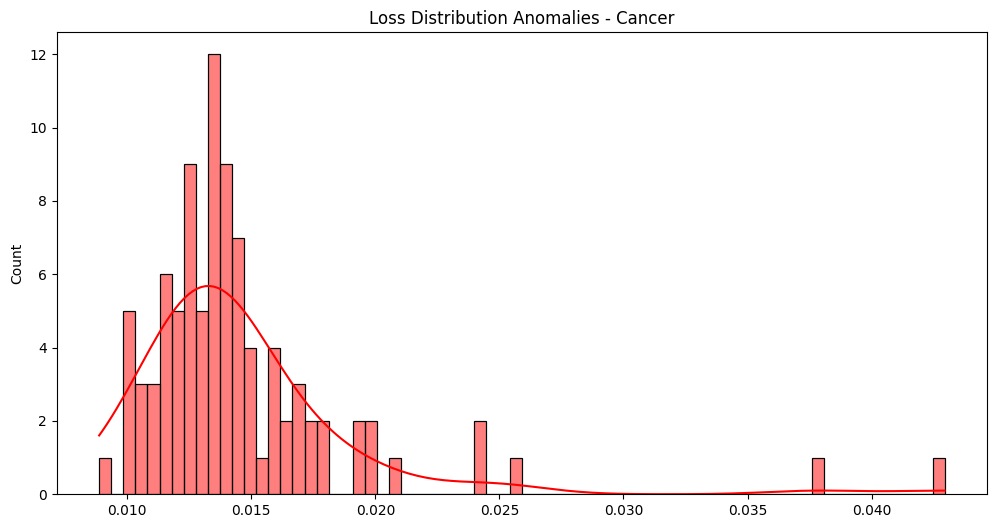

In [ ]:
plt.figure(figsize=(12,6)) #CLASS 1
plt.title('Loss Distribution Anomalies - Cancer')
sns.histplot(loss_dist[labels == 1], bins=70, kde=True, color='red');


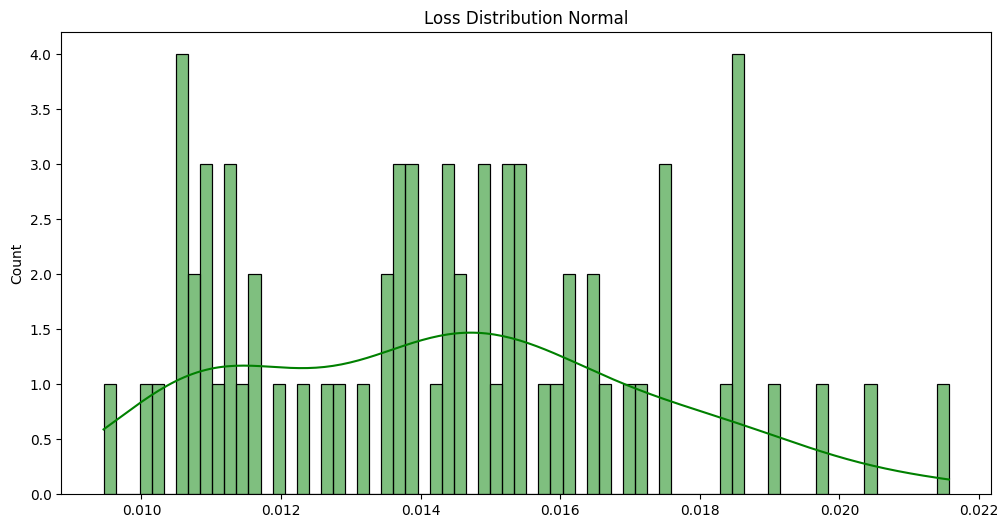

In [ ]:
plt.figure(figsize=(12,6)) #Class 0
plt.title('Loss Distribution Normal')
sns.histplot(loss_dist[labels == 0], bins=70, kde=True, color='green');

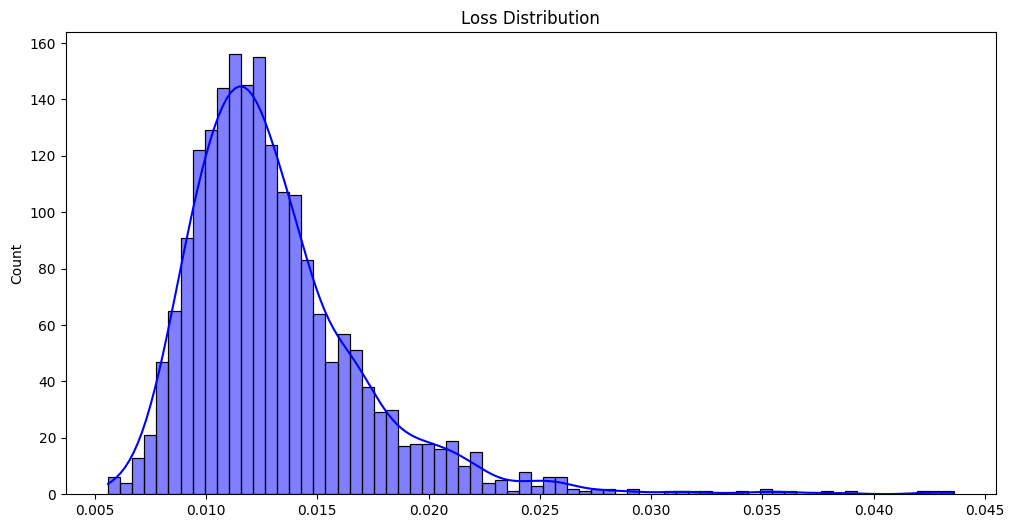

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.histplot(loss_dist, bins=70, kde=True, color='blue');

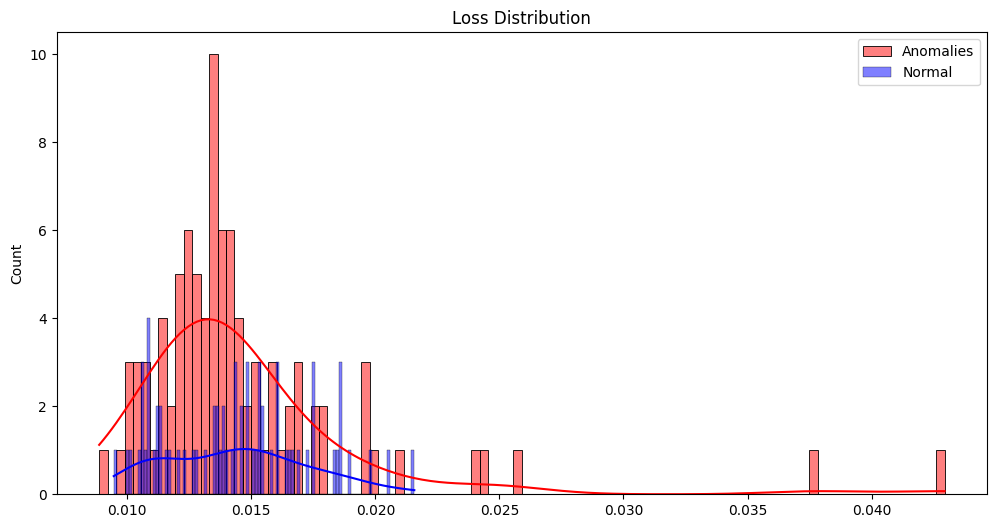

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')

# Slice loss_dist for anomalies (label 1)
loss_dist_anomalies = loss_dist[labels == 1]
sns.histplot(loss_dist_anomalies, bins=100, kde=True, color='red', label='Anomalies')

# Slice loss_dist for normal (label 0)
loss_dist_normal = loss_dist[labels == 0]
sns.histplot(loss_dist_normal, bins=100, kde=True, color='blue', label='Normal')

plt.legend()
plt.show()


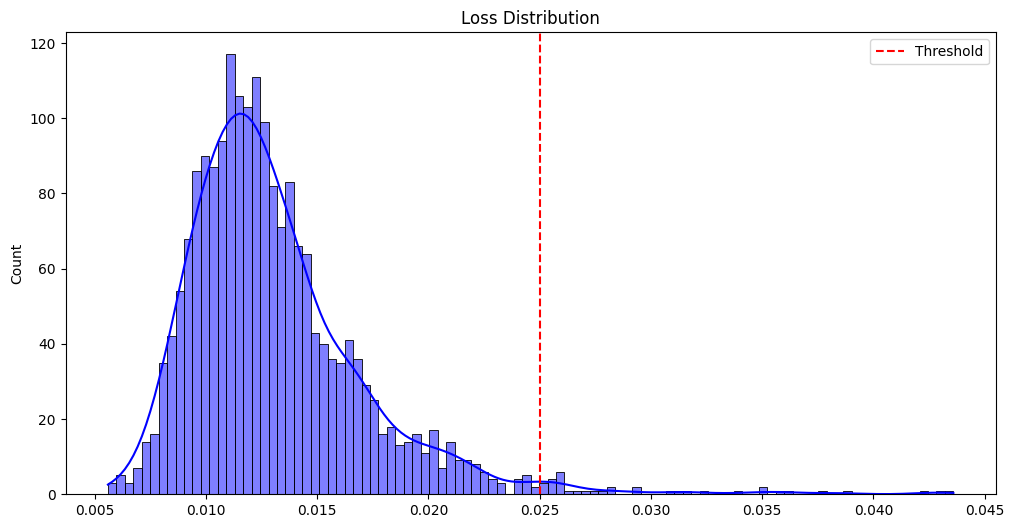

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')

# Plot the histogram of loss_dist
sns.histplot(loss_dist, bins=100, kde=True, color='blue')

# Calculate the threshold (e.g., 95th percentile)
threshold = 0.025

# Plot the threshold line
plt.axvline(threshold, 0.0, 10, color='r', linestyle='--', label='Threshold')

plt.legend()
plt.show()


In [ ]:
# @ROC:

In [ ]:
'''
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(labels, loss_dist, pos_label=1)
img_roc_auc = roc_auc_score(labels, loss_dist)

plt.plot(fpr, tpr, label='ROCAUC: %.3f' % (img_roc_auc))
print(f'ROCAUC: {img_roc_auc:.3f}')
'''

"\nfrom sklearn.metrics import roc_auc_score\nfrom sklearn.metrics import roc_curve\n\nfpr, tpr, _ = roc_curve(labels, loss_dist, pos_label=1)\nimg_roc_auc = roc_auc_score(labels, loss_dist)\n\nplt.plot(fpr, tpr, label='ROCAUC: %.3f' % (img_roc_auc))\nprint(f'ROCAUC: {img_roc_auc:.3f}')\n"

In [ ]:
upper_threshold = 0.025
y_pred = loss_dist.copy()
th = upper_threshold

y_pred[loss_dist < th] = 0
y_pred[loss_dist >= th] = 1

In [ ]:
'''
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(labels, y_pred)
sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt='g');
'''

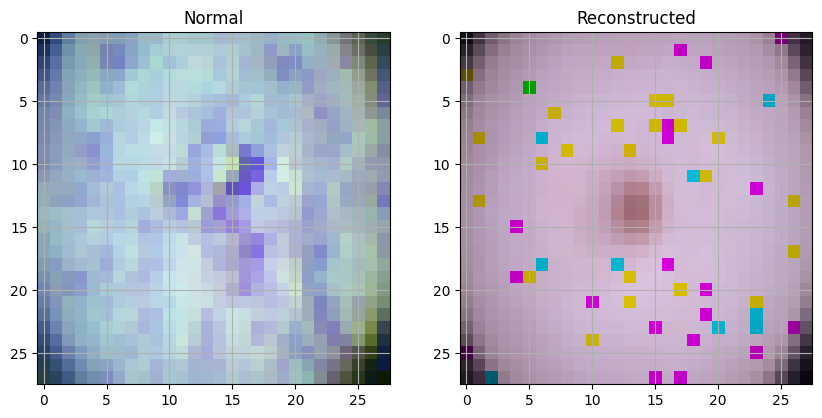

In [ ]:
clean_img = np.array(clean.iloc[1:2, 1:])

plt.figure(figsize=(10,8))
img = clean_img.reshape(28,28,3)
plt.subplot(1,2,1)
plt.imshow(img, interpolation='nearest')
plt.title('Normal')
plt.grid()

model.eval()
with torch.no_grad():
    rec = model(torch.from_numpy(clean_img/255).float().to(device).unsqueeze(0))[0, 0].cpu().numpy()

img1 = rec.reshape(28,28,3)
plt.subplot(1,2,2)
plt.imshow(img1, interpolation='nearest')
plt.title('Reconstructed')
plt.grid()
plt.show()


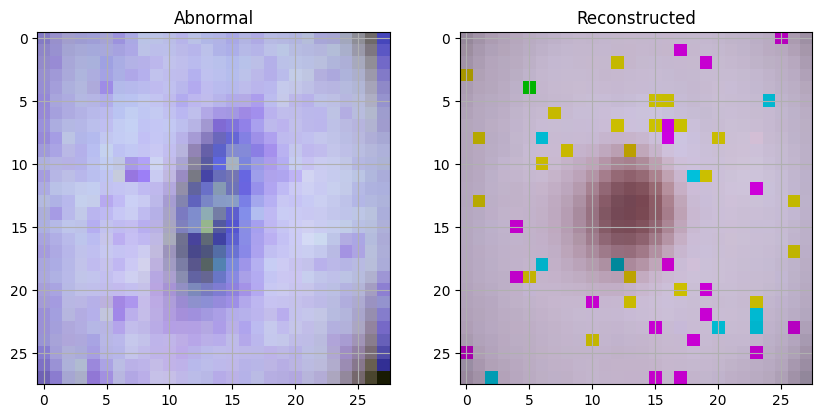

In [ ]:
anom_img = np.array(anom.iloc[1:2, 1:])

plt.figure(figsize=(10,8))
img = anom_img.reshape(28,28,3)
plt.subplot(1,2,1)
plt.imshow(img, interpolation='nearest')
plt.title('Abnormal')
plt.grid()

model.eval()
with torch.no_grad():
    rec = model(torch.from_numpy(anom_img/255).float().to(device).unsqueeze(0))[0, 0].cpu().numpy()

img1 = rec.reshape(28, 28, 3)
plt.subplot(1, 2, 2)
plt.imshow(img1, interpolation='nearest')
plt.title('Reconstructed')
plt.grid()
plt.show()
